# Sea level mean state bias diagnostic

In [1]:
import os
import cftime
import dask
import xarray as xr
import numpy as np
import nc_time_axis
import cartopy.mpl.ticker as cticker
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from dask.distributed import Client
client = Client(n_workers=1, threads_per_worker=8, processes=False)
client

Client Scheduler: inproc://128.196.236.68/21032/1 Dashboard: http://localhost:8787/status,Cluster Workers: 1 Cores: 8 Memory: 67.54 GB


In [2]:
import warnings
warnings.simplefilter("ignore")

from mem_track import used_memory
used_memory()

used 135.667969 MB


# Model

In [3]:
#### possible input info from external text file
# constant setting
syear = 1993           
fyear = 2007
tp_lat_region = [-90,90]     # extract model till latitude

Model_varname = ['tauuo','tauvo','zos','tos']
Area_name = ['areacello_cu','areacello_cv','areacello','areacello']

Model_name = ['JRA','CORE']
Model_legend_name = ['JRA55-do','CORE']

# standard model (interpolated to this model)
Model_standard = 'JRA'
Variable_standard = 'zos'
modeldir = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/GFDL/JRA/'
modelfile = 'JRA_zos.zarr'
path_standard = modeldir+modelfile

# inputs
modelin = {}
path = {}
model = Model_name[0]
modeldir = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/GFDL/JRA/'
modelfile = [['JRA_tauuo.zarr'],['JRA_tauvo.zarr'],['JRA_zos.zarr'],['JRA_tos.zarr']]
path[model]=[modeldir,modelfile]

model = Model_name[1]
modeldir = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/GFDL/CORE/'
modelfile = [['CORE_tauuo.zarr'],['CORE_tauvo.zarr'],['CORE_zos.zarr'],['CORE_tos.zarr']]
path[model]=[modeldir,modelfile]



for nmodel,model in enumerate(Model_name):
    modeldir = path[model][0]
    modelfile = path[model][1]
    multivar = []
    for file in modelfile :
        if len(file) == 1 :
            multivar.append([os.path.join(modeldir,file[0])])
        elif len(file) > 1 :
            multifile = []
            for ff in file :
                multifile.append(os.path.join(modeldir,ff))
            multivar.append(multifile)
    modelin[model] = multivar



In [4]:
# initialization of dict and list  (!!!!!!!! remove all previous read model info if exec !!!!!!!!!!)
nmodel = len(Model_name)
nvar = len(Model_varname)

ds_model_mlist = {}
mean_mlist = {}
season_mlist = {}

In [5]:
#### models
import sys
for nmodel,model in enumerate(Model_name):
    ds_model_list = {}
    mean_list = {}
    season_list = {}
    for nvar,var in enumerate(Model_varname):
        print('read %s %s'%(model,var))
        
        # read input data
        #-- single file
        if len(modelin[model][nvar]) == 1 :   
            ds_model = xr.open_zarr(modelin[model][nvar][0])            
        #-- multi-file merge (same variable)
        elif len(modelin[model][nvar]) > 1 :
            for nf,file in enumerate(modelin[model][nvar]):
                ds_model_sub = xr.open_zarr(file)
                if nf == 0 :
                    ds_model = ds_model_sub
                else:
                    ds_model = xr.concat([ds_model,ds_model_sub],dim='time',data_vars='minimal')
                 
        # crop data (time)
        da_model = ds_model[var]\
                          .where((ds_model['time.year'] >= syear)&\
                                 (ds_model['time.year'] <= fyear)\
                                 ,drop=True)
        da_model = da_model\
                          .where((ds_model.lat >= np.min(np.array(tp_lat_region)))&\
                                 (ds_model.lat <= np.max(np.array(tp_lat_region)))\
                                 ,drop=True)
        
        # store all model data
        ds_model_list[var] = da_model
        
        # calculate mean 
        mean_list[var] = ds_model_list[var].mean(dim='time').compute()
        ds_model_list[var] = ds_model_list[var]-mean_list[var]
        
        # calculate seasonality
        season_list[var] = ds_model_list[var].groupby('time.month').mean(dim='time').compute()
        ds_model_list[var] = ds_model_list[var].groupby('time.month')-season_list[var]

    mean_mlist[model] = mean_list
    season_mlist[model] = season_list
    ds_model_mlist[model] = ds_model_list

read JRA tauuo
read JRA tauvo
read JRA zos
read JRA tos
read CORE tauuo
read CORE tauvo
read CORE zos
read CORE tos


In [6]:
used_memory()

used 1376.234375 MB


In [7]:
#### possible input info from external text file
# constant setting
tp_lat_region = [-30,30]     # extract model till latitude

Model_varname = ['uo','vo']
Area_name = ['areacello_cu','areacello_cv']

Model_name = ['JRA']

# inputs
modelin = {}
path = {}
model = Model_name[0]
modeldir = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/GFDL/JRA/'
modelfile = [['JRA_uo_annmean.zarr'],['JRA_vo_annmean.zarr']]
path[model]=[modeldir,modelfile]



for nmodel,model in enumerate(Model_name):
    modeldir = path[model][0]
    modelfile = path[model][1]
    multivar = []
    for file in modelfile :
        if len(file) == 1 :
            multivar.append([os.path.join(modeldir,file[0])])
        elif len(file) > 1 :
            multifile = []
            for ff in file :
                multifile.append(os.path.join(modeldir,ff))
            multivar.append(multifile)
    modelin[model] = multivar



In [8]:
# initialization of dict and list  (!!!!!!!! remove all previous read model info if exec !!!!!!!!!!)
ds_model_mlist_ann = {}

In [9]:
#### models
import sys
for nmodel,model in enumerate(Model_name):
    ds_model_list = {}
    mean_list = {}
    season_list = {}
    for nvar,var in enumerate(Model_varname):
        print('read %s %s'%(model,var))
        
        # read input data
        #-- single file
        if len(modelin[model][nvar]) == 1 :   
            ds_model = xr.open_zarr(modelin[model][nvar][0])            
        #-- multi-file merge (same variable)
        elif len(modelin[model][nvar]) > 1 :
            for nf,file in enumerate(modelin[model][nvar]):
                ds_model_sub = xr.open_zarr(file)
                if nf == 0 :
                    ds_model = ds_model_sub
                else:
                    ds_model = xr.concat([ds_model,ds_model_sub],dim='time',data_vars='minimal')
                 
        da_model = ds_model[var]\
                          .where((ds_model.lat >= np.min(np.array(tp_lat_region)))&\
                                 (ds_model.lat <= np.max(np.array(tp_lat_region)))\
                                 ,drop=True)
        
        # store all model data
        ds_model_list[var] = da_model
        
    ds_model_mlist_ann[model] = ds_model_list

read JRA uo
read JRA vo


In [10]:
# import depth in ocean model

ds_static = xr.open_dataset('/storage2/chiaweih/OMIP/GFDL/JRA/OM4p25_JRA55do1.4_0netfw_cycle6/ocean_monthly.static.nc')
modeldims = ['yh','xh']
Coord_name = ['geolon','geolat']
ds_depth = xr.Dataset(coords={'lon':((modeldims[-2],modeldims[-1]),ds_static[Coord_name[0]].values),
                              'lat':((modeldims[-2],modeldims[-1]),ds_static[Coord_name[1]].values),
                                    modeldims[-2]:ds_static[modeldims[-2]].values,
                                    modeldims[-1]:ds_static[modeldims[-1]].values,})
ds_depth['deptho'] = ds_static.deptho.load()
ds_depth = ds_depth.rename({'yh':'y', 'xh':'x'})


da_depth = ds_depth.deptho.where((ds_depth.lat >= np.min(np.array(tp_lat_region)))&\
                                 (ds_depth.lat <= np.max(np.array(tp_lat_region)))\
                                 ,drop=True)

# Observation

In [11]:
#### possible input info from external text file
# constant setting
obs_year_range = [[1950,2011],[1993,2018,9]]


# standard model (interpolated to this model)
Model_standard = 'JRA'
tp_lat_region = [-30,30]     # extract model till latitude

Obs_varname = [['tx','ty'],['adt']]

Obs_name = ['WESwind','CMEMS']

# inputs
obsin = {}
obspath = {}

obs = Obs_name[0]
obsdir = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/WASWind/'
obsfile = [['waswind_v1_0_1.monthly.nc'],['waswind_v1_0_1.monthly.nc']]
obspath[obs]=[obsdir,obsfile]

obs = Obs_name[1]
obsdir = '/storage1/home1/chiaweih/Research/proj3_omip_sl/data/CMEMS/'
obsfile = [['dt_global_allsat_phy_l4_monthly_adt.nc']]
obspath[obs]=[obsdir,obsfile]


for nobs,obs in enumerate(Obs_name):
    obsdir = obspath[obs][0]
    obsfile = obspath[obs][1]
    multivar = []
    for file in obsfile :
        if len(file) == 1 :
            multivar.append([os.path.join(obsdir,file[0])])
        elif len(file) > 1 :
            multifile = []
            for ff in file :
                multifile.append(os.path.join(obsdir,ff))
            multivar.append(multifile)
    obsin[obs] = multivar

In [12]:
# initialization of dict and list  (!!!!!!!! remove all previous read model info if exec !!!!!!!!!!)
ds_obs_mlist = {}
obs_mean_mlist = {}
obs_season_mlist = {}

In [13]:
import spherical_area as sa

#### obs
for nobs,obs in enumerate(Obs_name):
    ds_obs_list = {}
    obs_mean_list = {}
    obs_season_list = {}
    for nvar,var in enumerate(Obs_varname[nobs]):
        print('read %s %s'%(obs,var))
        
        # read input data
        #-- single file
        if len(obsin[obs][nvar]) == 1 :  
            
            # find out dimension name 
            da = xr.open_dataset(obsin[obs][nvar][0],chunks={})
            obsdims = list(da[var].dims)
        
            ds_obs = xr.open_dataset(obsin[obs][nvar][0],chunks={obsdims[0]:50,obsdims[1]:50,obsdims[2]:50},use_cftime=True)
         
        #-- multi-file merge (same variable)
        elif len(obsin[obs][nvar]) > 1 :
            for nf,file in enumerate(obsin[obs][nvar]):
                # find out dimension name 
                da = xr.open_dataset(file,chunks={})
                obsdims = list(da[var].dims)
            
                ds_obs_sub = xr.open_dataset(file,chunks={obsdims[0]:50,obsdims[1]:50,obsdims[2]:50},use_cftime=True)
                if nf == 0 :
                    ds_obs = ds_obs_sub
                else:
                    ds_obs = xr.concat([ds_obs,ds_obs_sub],dim='time',data_vars='minimal')
                    
        ############## CMEMS ##############       
        if obs in ['CMEMS']:
            syear_obs = obs_year_range[nobs][0]
            fyear_obs = obs_year_range[nobs][1]
            fmon_obs = obs_year_range[nobs][2]
            #### create time axis for overlapping period
            timeax = xr.cftime_range(start=cftime.datetime(syear_obs,1,1),end=cftime.datetime(fyear_obs,fmon_obs,1),freq='MS')
            timeax = timeax.to_datetimeindex()    # cftime => datetime64
            ds_obs.time.values = timeax                   
                 
            # calculate global mean sea level 
            da_area = sa.da_area(ds_obs, lonname='longitude', latname='latitude', 
                                 xname='longitude', yname='latitude', model=None)
            da_glo_mean = (ds_obs*da_area).sum(dim=['longitude','latitude'])/da_area.sum(dim=['longitude','latitude'])
            ds_obs = ds_obs-da_glo_mean

            # rename 
            ds_obs = ds_obs.rename({'longitude':'lon','latitude':'lat'})
        else:
            syear_obs = obs_year_range[nobs][0]
            fyear_obs = obs_year_range[nobs][1]
            #### create time axis for overlapping period
            timeax = xr.cftime_range(start=cftime.datetime(syear_obs,1,1),end=cftime.datetime(fyear_obs,12,31),freq='MS')
            timeax = timeax.to_datetimeindex()    # cftime => datetime64
            ds_obs.time.values = timeax
            
     
        # crop data (time)
        ds_obs = ds_obs[var]\
                          .where((ds_obs['time.year'] >= syear)&\
                                 (ds_obs['time.year'] <= fyear)\
                                 ,drop=True)
        ds_obs = ds_obs\
                          .where((ds_obs.lat >= np.min(np.array(tp_lat_region)))&\
                                 (ds_obs.lat <= np.max(np.array(tp_lat_region)))\
                                 ,drop=True)
        
        # store all model data
        ds_obs_list[var] = ds_obs
        
        # calculate mean 
        obs_mean_list[var] = ds_obs_list[var].mean(dim='time').compute()
        ds_obs_list[var] = ds_obs_list[var]-obs_mean_list[var]
        
        # calculate seasonality
        obs_season_list[var] = ds_obs_list[var].groupby('time.month').mean(dim='time').compute()
        ds_obs_list[var] = ds_obs_list[var].groupby('time.month')-obs_season_list[var]

    obs_mean_mlist[obs] = obs_mean_list
    obs_season_mlist[obs] = obs_season_list
    ds_obs_mlist[obs] = ds_obs_list

read WESwind tx
read WESwind ty
read CMEMS adt


In [14]:
used_memory()

used 1920.636719 MB


# Regridding

In [15]:
#### models
da_model_standard = xr.open_zarr(path_standard).isel(time=0).load()     

da_model_standard = da_model_standard\
                  .where((da_model_standard.lat >= np.min(np.array(tp_lat_region)))&\
                         (da_model_standard.lat <= np.max(np.array(tp_lat_region)))\
                         ,drop=True)

In [16]:
used_memory()

used 1935.929688 MB


In [17]:
import importlib
import create_ocean_mask
importlib.reload(create_ocean_mask)
from create_ocean_mask import levitus98

# # calculate zonal mean in the Pacific Basin
# from create_ocean_mask import levitus98

da_pacific = levitus98(da_model_standard,
                       basin=['pac'],
                       reuse_weights=True, 
                       newvar=True, 
                       lon_name='x',
                       lat_name='y', 
                       new_regridder_name='')

No previous Atlantic regridder file
No previous Indian regridder file
Create weight file: basin_pacific_regrid.nc


In [18]:
import xesmf as xe
Model_varname = ['tauuo','tauvo','zos','tos']
Model_name = ['JRA','CORE']
# Regridding to the tracer points
regridder_mlist = {}
for nmodel,model in enumerate(Model_name):
    regridder_list = {}
    for nvar,var in enumerate(Model_varname):
        if (var in [Variable_standard]) & (model in [Model_standard]):
            print('model variable same as standard model variable')
        else:
            regridder = xe.Regridder(season_mlist[model][var],
                                     da_model_standard,
                                     'bilinear',
                                     filename='%s_%s2%s_%s.nc'%(model,var,Model_standard,Variable_standard),
                                     periodic=True,
                                     reuse_weights=False)
            regridder_list['%s_%s2%s_%s'%(model,var,Model_standard,Variable_standard)] = regridder
    regridder_mlist[model] = regridder_list
    
    

# v2t.clean_weight_file() 
# u2t.clean_weight_file()

Overwrite existing file: JRA_tauuo2JRA_zos.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: JRA_tauvo2JRA_zos.nc 
 You can set reuse_weights=True to save computing time.
model variable same as standard model variable
Overwrite existing file: JRA_tos2JRA_zos.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: CORE_tauuo2JRA_zos.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: CORE_tauvo2JRA_zos.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: CORE_zos2JRA_zos.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: CORE_tos2JRA_zos.nc 
 You can set reuse_weights=True to save computing time.


In [19]:
#### regridding mean field 
for nmodel,model in enumerate(Model_name):
    for nvar,var in enumerate(Model_varname):
        if (var in [Variable_standard]) & (model in [Model_standard]):
            print('model variable same as standard model variable')
        else:
            mean_mlist[model][var] = \
              regridder_mlist[model]['%s_%s2%s_%s'%(model,var,Model_standard,Variable_standard)](mean_mlist[model][var])
            mean_mlist[model][var]['x'] = da_model_standard.x
            mean_mlist[model][var]['y'] = da_model_standard.y

model variable same as standard model variable


In [20]:
import xesmf as xe
Model_varname = ['uo','vo']
Model_name = ['JRA']
# Regridding to the tracer points
regridder_mlist = {}
for nmodel,model in enumerate(Model_name):
    regridder_list = {}
    for nvar,var in enumerate(Model_varname):
        if (var in [Variable_standard]) & (model in [Model_standard]):
            print('model variable same as standard model variable')
        else:
            regridder = xe.Regridder(ds_model_mlist_ann[model][var],
                                     da_model_standard,
                                     'bilinear',
                                     filename='%s_%s2%s_%s.nc'%(model,var,Model_standard,Variable_standard),
                                     periodic=True,
                                     reuse_weights=False)
            regridder_list['%s_%s2%s_%s'%(model,var,Model_standard,Variable_standard)] = regridder
    regridder_mlist[model] = regridder_list
    
    

# v2t.clean_weight_file() 
# u2t.clean_weight_file()

Overwrite existing file: JRA_uo2JRA_zos.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: JRA_vo2JRA_zos.nc 
 You can set reuse_weights=True to save computing time.


In [21]:
#### regridding annmean field 
for nmodel,model in enumerate(Model_name):
    for nvar,var in enumerate(Model_varname):
        if (var in [Variable_standard]) & (model in [Model_standard]):
            print('model variable same as standard model variable')
        else:
            ds_model_mlist_ann[model][var] = \
              regridder_mlist[model]['%s_%s2%s_%s'%(model,var,Model_standard,Variable_standard)]\
              (ds_model_mlist_ann[model][var].isel(time=0))
            ds_model_mlist_ann[model][var]['x'] = da_model_standard.x
            ds_model_mlist_ann[model][var]['y'] = da_model_standard.y

In [22]:
# create regridder
for nobs,obs in enumerate(Obs_name):
    regridder_list = {}
    for nvar,var in enumerate(Obs_varname[nobs]):
        regridder = xe.Regridder(obs_season_mlist[obs][var], 
                                 da_model_standard, 
                                 'bilinear',
                                 filename='%s_%s2%s_%s.nc'%(obs,var,Model_standard,Variable_standard),
                                 periodic=True,
                                 reuse_weights=False)
        regridder_list['%s_%s2%s_%s'%(obs,var,Model_standard,Variable_standard)] = regridder
    regridder_mlist[obs] = regridder_list

Overwrite existing file: WESwind_tx2JRA_zos.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: WESwind_ty2JRA_zos.nc 
 You can set reuse_weights=True to save computing time.
Overwrite existing file: CMEMS_adt2JRA_zos.nc 
 You can set reuse_weights=True to save computing time.


In [23]:
#### regridding seasonal field 
for nobs,obs in enumerate(Obs_name):
    for nvar,var in enumerate(Obs_varname[nobs]):
        obs_mean_mlist[obs][var] = \
          regridder_mlist[obs]['%s_%s2%s_%s'%(obs,var,Model_standard,Variable_standard)](obs_mean_mlist[obs][var])
        obs_mean_mlist[obs][var]['x'] = da_model_standard.x
        obs_mean_mlist[obs][var]['y'] = da_model_standard.y

# Derive Barotropic Stream function

In [24]:
import importlib
import dynamical_balance2
importlib.reload(dynamical_balance2)
from dynamical_balance2 import barotropic_streamfunc


da_stream = barotropic_streamfunc(ds_model_mlist_ann['JRA']['vo'].load()*da_pacific,da_depth,dep_dim='z')*da_pacific

# Derive wind stress convergence

In [25]:
import importlib
import dynamical_balance2
importlib.reload(dynamical_balance2)
from dynamical_balance2 import conv_tau


obs_mean_mlist['WESwind']['conv_tx'],obs_mean_mlist['WESwind']['conv_ty'] = conv_tau(
                                               obs_mean_mlist['WESwind']['tx'],
                                               obs_mean_mlist['WESwind']['ty'])
Model_name = ['JRA','CORE']
for nmodel,model in enumerate(Model_name):
    mean_mlist[model]['conv_tauuo'],mean_mlist[model]['conv_tauvo'] = conv_tau(
                                               mean_mlist[model]['tauuo'],
                                               mean_mlist[model]['tauvo'])

# Derive Ekman upwelling/downwelling and wind stress curl

In [26]:
import importlib
import dynamical_balance2
importlib.reload(dynamical_balance2)
from dynamical_balance2 import curl_tau, ekman_pumping2

Model_name = ['JRA','CORE']
obs_mean_mlist['WESwind']['Ek_tx'],obs_mean_mlist['WESwind']['Ek_ty'] = ekman_pumping2(
                                                      obs_mean_mlist['WESwind']['tx'],
                                                      obs_mean_mlist['WESwind']['ty'],
                                                      eq_mask=True)
obs_mean_mlist['WESwind']['curl_tx'],obs_mean_mlist['WESwind']['curl_ty'] = curl_tau(
                                               obs_mean_mlist['WESwind']['tx'],
                                               obs_mean_mlist['WESwind']['ty'])

for nmodel,model in enumerate(Model_name):
    mean_mlist[model]['Ek_tauuo'],mean_mlist[model]['Ek_tauvo'] = ekman_pumping2(
                                                      mean_mlist[model]['tauuo'],
                                                      mean_mlist[model]['tauvo'],
                                                      eq_mask=True)
    mean_mlist[model]['curl_tauuo'],mean_mlist[model]['curl_tauvo'] = curl_tau(
                                               mean_mlist[model]['tauuo'],
                                               mean_mlist[model]['tauvo'])

## Derive Ekman transport and Sverdrup transport

In [27]:
import importlib
import dynamical_balance2
importlib.reload(dynamical_balance2)
from dynamical_balance2 import sverdrup_transport, ekman_transport


obs_mean_mlist['WESwind']['Ek_tranx'],obs_mean_mlist['WESwind']['Ek_trany'] = ekman_transport(
                                                      obs_mean_mlist['WESwind']['tx'],
                                                      obs_mean_mlist['WESwind']['ty'],
                                                      eq_mask=True)

obs_mean_mlist['WESwind']['Sv_tranx'],obs_mean_mlist['WESwind']['Sv_trany'],\
obs_mean_mlist['WESwind']['Sv_stream'] = sverdrup_transport(obs_mean_mlist['WESwind']['tx']*da_pacific,
                                                            obs_mean_mlist['WESwind']['ty']*da_pacific)

for nmodel,model in enumerate(Model_name):
    mean_mlist[model]['Ek_tranx'],mean_mlist[model]['Ek_trany'] = ekman_transport(
                                                      mean_mlist[model]['tauuo'],
                                                      mean_mlist[model]['tauvo'],
                                                      eq_mask=True)
    mean_mlist[model]['Sv_tranx'],mean_mlist[model]['Sv_trany'],\
    mean_mlist[model]['Sv_stream']= sverdrup_transport(mean_mlist[model]['tauuo']*da_pacific,
                                                       mean_mlist[model]['tauvo']*da_pacific)

# Plotting 

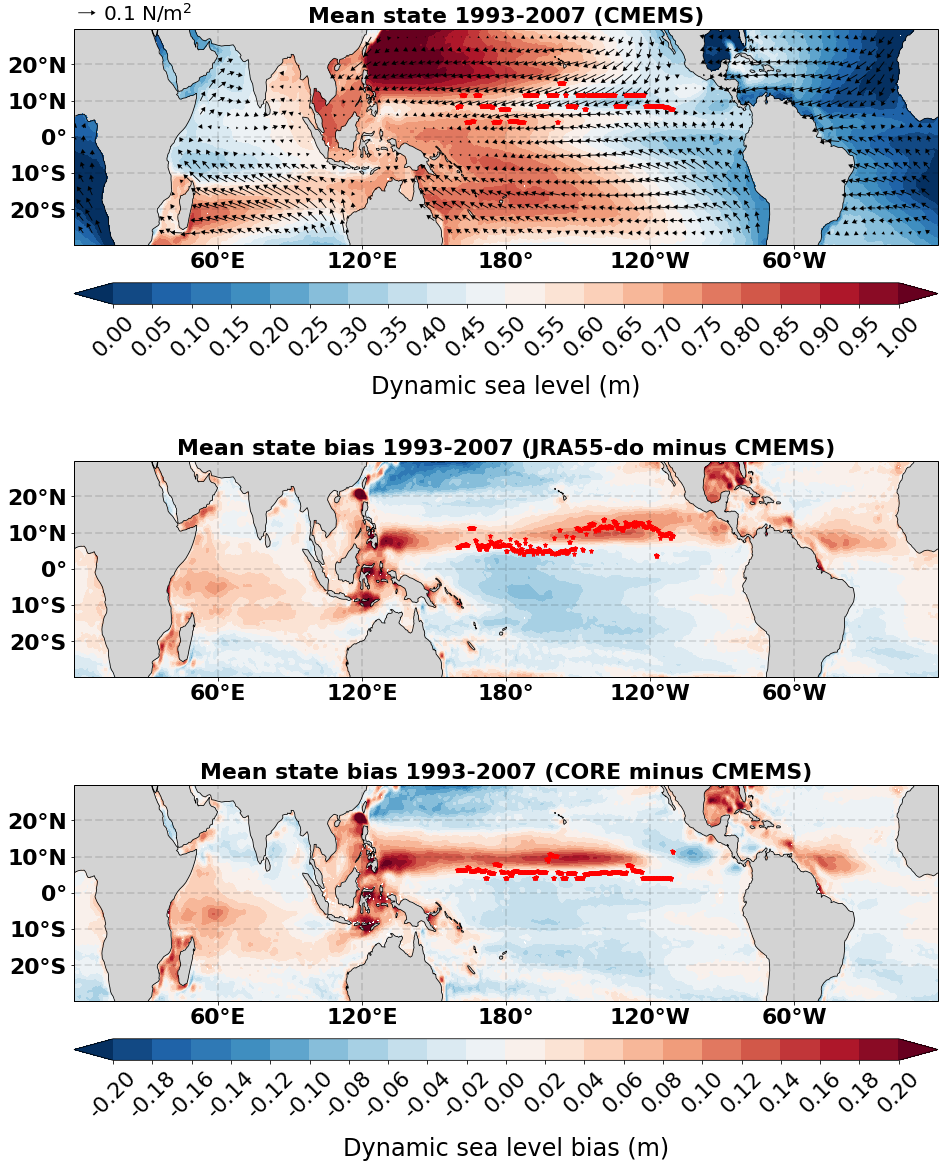

In [29]:
# comparing zos  
import cartopy.mpl.ticker as cticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

fig=plt.figure(2,figsize=(30,15))
devy = 0.30
abslevel=np.linspace(0, 1, 21)
level=np.linspace(-0.2, 0.2, 21)

ax2=fig.add_axes([0,0,0.5,0.20],projection=ccrs.PlateCarree(central_longitude=180))
    
im=((obs_mean_mlist['CMEMS']['adt']))\
                 .plot.contourf(x='lon',
                                y='lat',
                                ax=ax2, 
                                levels=abslevel, 
                                extend='both', 
                                cmap='RdBu_r',
                                transform=ccrs.PlateCarree(central_longitude=0))


da_conv=(obs_mean_mlist['WESwind']['conv_tx']+obs_mean_mlist['WESwind']['conv_ty'])\
        .where((da_pacific.lat>0)&
               (da_pacific.lat<15)&
               (da_pacific.lon<-110)&
               (da_pacific.lon>-200),drop=True)

xy_loc = []
for nx,x in enumerate(da_conv.x):
    try:
        ind = np.argmax(da_conv[:,nx].values)
        xy_loc.append([x.values,da_conv.y.values[ind]])
    except ValueError:
        xy_loc.append([x.values,da_conv.y.values[ind]])

for loc in xy_loc:
    ax2.plot(loc[0],loc[1],  markersize=5, marker='*', color='red',transform=ccrs.PlateCarree(central_longitude=0))

q=ax2.quiver(obs_mean_mlist['WESwind']['tx'].lon.values[::15, ::15],
             obs_mean_mlist['WESwind']['tx'].lat.values[::15, ::15],
             obs_mean_mlist['WESwind']['tx'].values[::15, ::15],
             obs_mean_mlist['WESwind']['ty'].values[::15, ::15],
             scale=5,units='width',headwidth=6,headaxislength=5,headlength=5,width=0.001,
             transform=ccrs.PlateCarree(central_longitude=0))
qk = ax2.quiverkey(q, 0.01, 0.215, 0.1, r'0.1 N/m$^2$', labelpos='E',
                   coordinates='figure',fontproperties={'size':20})


cb=im.colorbar
cb.remove()
cbaxes=fig.add_axes([0,0-0.055,0.4,0.02])
cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal')
cbar.set_ticks(abslevel)
cbar.set_ticklabels(["%0.2f"%(n) for n in abslevel]) #m => mm
cbar.ax.tick_params(labelsize=22,rotation=45) 
cbar.set_label(label='Dynamic sea level (m)',size=24, labelpad=15)
ax2.coastlines(resolution='110m',linewidths=0.8)
ax2.add_feature(cfeature.LAND,color='lightgrey')

ax2.set_xticks([60,120,180,240,300], crs=ccrs.PlateCarree())
ax2.set_xticklabels([60,120,180,-120,-60], color='black', weight='bold',size=22)
ax2.set_yticks([-20,-10,0,10,20], crs=ccrs.PlateCarree())
ax2.set_yticklabels([-20,-10,0,10,20], color='black', weight='bold',size=22)
ax2.yaxis.tick_left()

lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.grid(linewidth=2, color='black', alpha=0.1, linestyle='--')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('Mean state 1993-2007 (CMEMS)', color='black', weight='bold',size=22)
ax2.set_aspect('auto')

#########################################################################################
# fig.text(-0.05,0.25,'a',size=30)
for nmodel,model in enumerate(Model_name):
    
    ax2=fig.add_axes([0,0-0.1-devy*(nmodel+1),0.5,0.2],projection=ccrs.PlateCarree(central_longitude=180))
    # ax2.set_extent([-180,180,-60,60],crs=ccrs.PlateCarree())
    da_diff = (mean_mlist[model]['zos']-obs_mean_mlist['CMEMS']['adt'])
    im=(da_diff-da_diff.mean(dim=['x','y']))\
                 .plot.contourf(x='lon',
                                y='lat',
                                ax=ax2, 
                                levels=level, 
                                extend='both', 
                                cmap='RdBu_r',
                                transform=ccrs.PlateCarree(central_longitude=0))

    cb=im.colorbar
    cb.remove()
    
#     q=ax2.quiver(mean_mlist[model]['tauuo'].lon.values[::30, ::30],
#                  mean_mlist[model]['tauuo'].lat.values[::30, ::30],
#                  (mean_mlist[model]['tauuo'].values[::30, ::30]-\
#                  obs_mean_mlist['WESwind']['tx'].values[::30, ::30]),
#                  (mean_mlist[model]['tauvo'].values[::30, ::30]-\
#                  obs_mean_mlist['WESwind']['ty'].values[::30, ::30]),
#                  scale=0.5,units='width',headwidth=6,headaxislength=5,headlength=5,width=0.001,
#                  transform=ccrs.PlateCarree(central_longitude=0))
    
    da_conv=(mean_mlist[model]['conv_tauuo']+mean_mlist[model]['conv_tauvo'])\
            .where((da_pacific.lat>0)&
                   (da_pacific.lat<15)&
                   (da_pacific.lon<-110)&
                   (da_pacific.lon>-200),drop=True)

    xy_loc = []
    for nx,x in enumerate(da_conv.x):
        try:
            ind = np.argmax(da_conv[:,nx].values)
            xy_loc.append([x.values,da_conv.y.values[ind]])
        except ValueError:
            xy_loc.append([x.values,da_conv.y.values[ind]])
    
    for loc in xy_loc:
        ax2.plot(loc[0],loc[1],  markersize=5, marker='*', color='red',transform=ccrs.PlateCarree(central_longitude=0))
    
    if nmodel == len(Model_name)-1 :
        cbaxes=fig.add_axes([0,0-0.1-devy*(nmodel+1)-0.055,0.4,0.02])
        cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal')
        cbar.set_ticks(level)
        cbar.set_ticklabels(["%0.2f"%(n) for n in level]) #m => mm
        cbar.ax.tick_params(labelsize=22,rotation=45) 
        cbar.set_label(label='Dynamic sea level bias (m)',size=24, labelpad=15)
    ax2.coastlines(resolution='110m',linewidths=0.8)
    ax2.add_feature(cfeature.LAND,color='lightgrey')

    ax2.set_xticks([60,120,180,240,300], crs=ccrs.PlateCarree())
    ax2.set_xticklabels([60,120,180,-120,-60], color='black', weight='bold',size=22)
    ax2.set_yticks([-20,-10,0,10,20], crs=ccrs.PlateCarree())
    ax2.set_yticklabels([-20,-10,0,10,20], color='black', weight='bold',size=22)
    ax2.yaxis.tick_left()

    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax2.xaxis.set_major_formatter(lon_formatter)
    ax2.yaxis.set_major_formatter(lat_formatter)
    ax2.grid(linewidth=2, color='black', alpha=0.1, linestyle='--')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.set_title('Mean state bias 1993-2007 (%s minus CMEMS)'%Model_legend_name[nmodel], color='black', weight='bold',size=22)
    ax2.set_aspect('auto')

fig.savefig('../figure/figure1.pdf', dpi=300, facecolor='w', edgecolor='w',
                orientation='portrait', papertype=None, format=None,
                transparent=False, bbox_inches="tight", pad_inches=None,
                frameon=None)


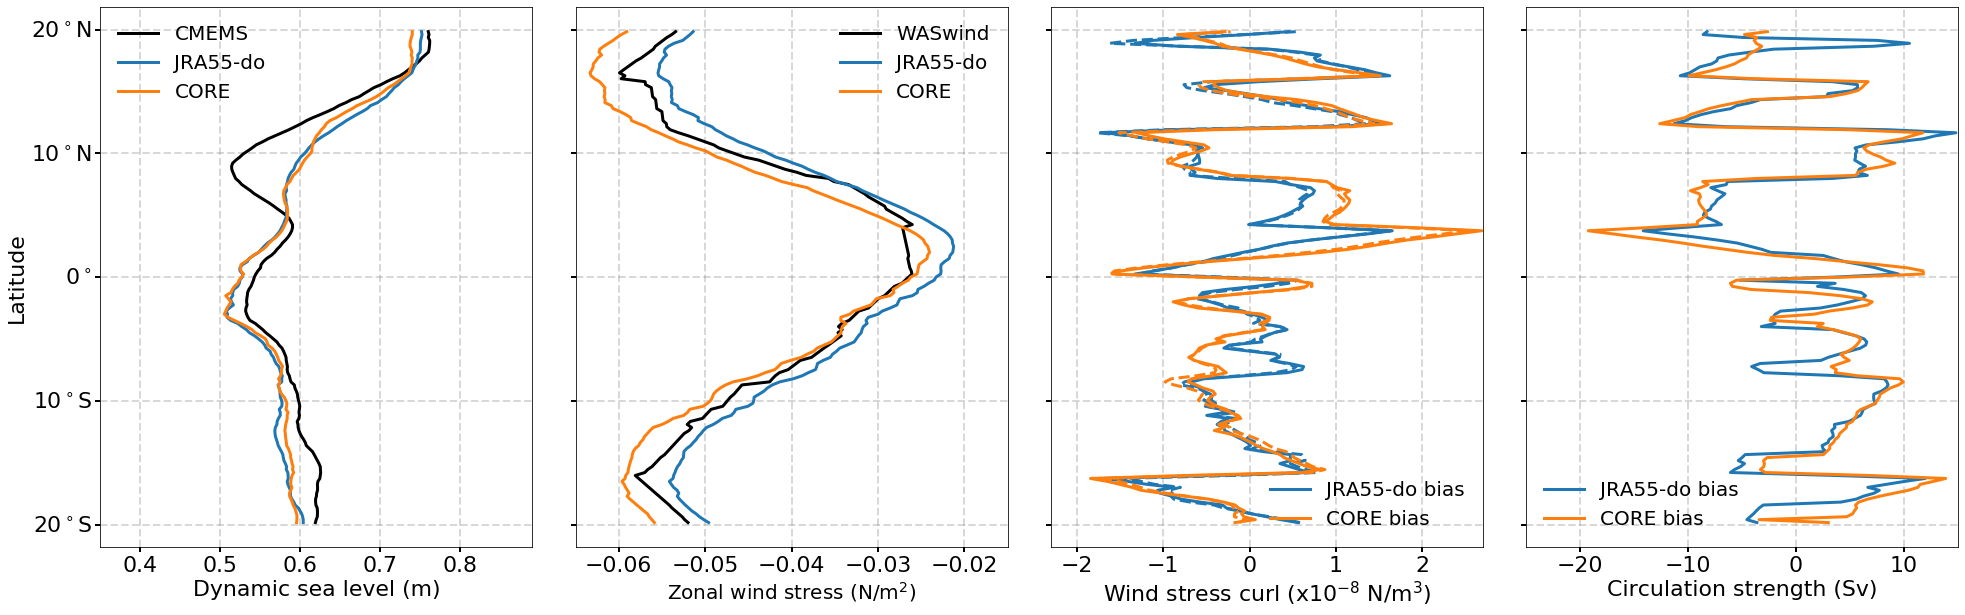

In [32]:
# comparing zos  
import cartopy.mpl.ticker as cticker
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

fig=plt.figure(2,figsize=(30,15))
devy = 0.25
level=np.linspace(-0.2, 0.2, 21)


    
#########################################################################################  
ax2=fig.add_axes([0,0,0.2,0.5])

da_obs_mean = (obs_mean_mlist['CMEMS']['adt'])
(da_obs_mean*da_pacific).where((da_pacific.lat>-20)&(da_pacific.lat<20))\
                       .mean(dim=['x']).plot(ax=ax2,y='y',linewidth=3.0,label='CMEMS',color='k')

colors=['C0','C1']
for nmodel, model in enumerate(Model_name):

    #### plotting
    da_mean = (mean_mlist[model]['zos'])
    da_mean_bias = (da_mean-da_obs_mean)   
    
    norm = -(da_mean*da_pacific).where((da_pacific.lat>-20)&(da_pacific.lat<20)).mean(dim=['x','y']).values\
           +(da_obs_mean*da_pacific).where((da_pacific.lat>-20)&(da_pacific.lat<20)).mean(dim=['x','y']).values
#     print(-(da_mean*da_pacific).where((da_pacific.lat>-20)&(da_pacific.lat<20)).mean(dim=['x','y']),(da_obs_mean*da_pacific).where((da_pacific.lat>-20)&(da_pacific.lat<20)).mean(dim=['x','y']))
        
    ((da_mean*da_pacific).where((da_pacific.lat>-20)&(da_pacific.lat<20))\
                        .mean(dim='x')+norm).plot(ax=ax2,y='y',linewidth=3.0,label='%s'%Model_legend_name[nmodel],color=colors[nmodel])
    
#     (da_mean*da_pacific).where((da_pacific.lat>-20)&(da_pacific.lat<20))\
#                         .mean(dim='x').plot(ax=ax2,y='y',linewidth=3.0,label='%s'%Model_legend_name[nmodel],color=colors[nmodel])
##     (da_mean_bias*da_pacific).where((da_pacific.lat>-20)&(da_pacific.lat<20))\
##                         .mean(dim='x').plot(ax=ax3,linewidth=2.0,linestyle='dashed',label='%s bias'%model,color=colors[nmodel])

ax2.set_xlim([0.35,0.89])
ax2.set_yticks([-20,-10,0,10,20])
ax2.set_yticklabels(['20$^\circ$S','10$^\circ$S','0$^\circ$','10$^\circ$N','20$^\circ$N'], color='black',size=22)
ax2.tick_params(axis='y',labelsize=22,length=5,width=2) 
ax2.tick_params(axis='x',labelsize=22,length=5,width=2) 
ax2.grid(linewidth=2, color='grey', alpha=0.3, linestyle='--')
ax2.set_ylabel('Latitude',size=22)
ax2.set_xlabel('Dynamic sea level (m)',size=22)
ax2.set_title('',color='black', weight='bold',size=22)
ax2.legend(loc='upper left',fontsize=20,frameon=False)
# ax2.set_ylim([np.min(level),np.max(level)])


######################################################################################### 
ax2=fig.add_axes([0.22,0,0.2,0.5])
da_obs_mean = (obs_mean_mlist['WESwind']['tx'])
(da_obs_mean*da_pacific).where((da_pacific.lat<20)&(da_pacific.lat>-20))\
                        .mean(dim=['x']).plot(ax=ax2,y='y',linewidth=3.0,label='WASwind',color='k')

colors=['C0','C1']
for nmodel, model in enumerate(Model_name):

    #### plotting
    da_mean = (mean_mlist[model]['tauuo'])
    da_mean_bias = da_mean-da_obs_mean  
    
    (da_mean*da_pacific).where((da_pacific.lat<20)&(da_pacific.lat>-20))\
                       .mean(dim=['x']).plot(ax=ax2,y='y',linewidth=3.0,label='%s'%Model_legend_name[nmodel],color=colors[nmodel])
#     (da_mean_bias*da_pacific).where((da_pacific.lat<20)&(da_pacific.lat>-20))\
#                        .mean(dim=['x']).plot(ax=ax3,linewidth=2.0,linestyle='dashed',label='%s bias'%model,color=colors[nmodel])

    
ax2.set_yticks([-20,-10,0,10,20])
ax2.set_xlim([-0.065,-0.015])
# ax2.set_yticklabels(['20$^\circ$S','10$^\circ$S','0$^\circ$','10$^\circ$N','20$^\circ$N'], color='black',size=22)
ax2.set_yticklabels(['','','','',''], color='black',size=22)
ax2.tick_params(axis='y',labelsize=22,length=5,width=2) 
ax2.tick_params(axis='x',labelsize=22,length=5,width=2) 
ax2.grid(linewidth=2, color='grey', alpha=0.3, linestyle='--')
ax2.set_ylabel('',size=22)
ax2.set_xlabel('Zonal wind stress (N/m$^2$)',size=20)
ax2.set_title('',color='black', weight='bold',size=22)
ax2.legend(loc='upper right',fontsize=20,frameon=False)


######################################################################################### 
ax2=fig.add_axes([0.44,0,0.2,0.5])

da_obs_mean = (obs_mean_mlist['WESwind']['curl_tx']+obs_mean_mlist['WESwind']['curl_ty'])\
              .where((da_pacific.lat<20)&(da_pacific.lat>-20))*1e8
# (da_obs_mean*da_pacific).mean(dim=['x']).plot(ax=ax2,linewidth=3.0,label='WASwind',color='k')
da_obs_mean_zonal = (obs_mean_mlist['WESwind']['curl_tx'])\
              .where((da_pacific.lat<20)&(da_pacific.lat>-20))*1e8

colors=['C0','C1']
for nmodel, model in enumerate(Model_name):

    #### plotting
    da_mean = (mean_mlist[model]['curl_tauuo']+mean_mlist[model]['curl_tauvo'])\
               .where((da_pacific.lat<20)&(da_pacific.lat>-20))*1e8
    da_mean_zonal = (mean_mlist[model]['curl_tauuo'])\
               .where((da_pacific.lat<20)&(da_pacific.lat>-20))*1e8
    da_mean_bias = da_mean-da_obs_mean  
    da_mean_zonal_bias = da_mean_zonal-da_obs_mean_zonal 
    
#     (da_mean*da_pacific).mean(dim=['x']).plot(ax=ax2,linewidth=2.0,label='%s'%model,color=colors[nmodel])
    (da_mean_bias*da_pacific).mean(dim=['x']).plot(ax=ax2,
                                                   y='y',
                                                   linewidth=3.0,
                                                   linestyle='solid',
                                                   label='%s bias'%Model_legend_name[nmodel],
                                                   color=colors[nmodel])
    (da_mean_zonal_bias*da_pacific).mean(dim=['x']).plot(ax=ax2,
                                                   y='y',
                                                   linewidth=3.0,
                                                   linestyle='dashed',
                                                   color=colors[nmodel])

    
ax2.set_yticks([-20,-10,0,10,20])
# ax2.set_yticklabels(['20$^\circ$S','10$^\circ$S','0$^\circ$','10$^\circ$N','20$^\circ$N'], color='black',size=22)
ax2.set_yticklabels(['','','','',''], color='black',size=22)
ax2.set_xlim([-2.3,2.7])
ax2.tick_params(axis='y',labelsize=22,length=5,width=2) 
ax2.tick_params(axis='x',labelsize=22,length=5,width=2) 
ax2.grid(linewidth=2, color='grey', alpha=0.3, linestyle='--')
ax2.set_ylabel('',size=22)
ax2.set_xlabel('Wind stress curl (x10$^{-8}$ N/m$^3$)',size=22)
ax2.set_title('',color='black', weight='bold',size=22)
ax2.legend(loc='lower right',fontsize=20,frameon=False)


# ######################################################################################### 
ax2=fig.add_axes([0.66,0,0.2,0.5])

# da_pacific_mask = da_pacific.where(da_pacific.lon>-180,other=np.nan)

da_obs_mean = (obs_mean_mlist['WESwind']['Sv_stream'])/1e6
sign = (da_obs_mean*da_pacific).sum(dim='x')/np.abs((da_obs_mean*da_pacific).sum(dim='x'))


# (sign*(np.abs(da_obs_mean*da_pacific))\
#        .where((da_pacific.lat<20)&(da_pacific.lat>-20))\
#        .max(dim=['x'])).plot(ax=ax2,linewidth=2.0,label='WASwind',color='k')

colors=['C0','C1']
for nmodel, model in enumerate(Model_name):

    #### plotting
    da_mean = (mean_mlist[model]['Sv_stream']).where((da_pacific.lat<20)&(da_pacific.lat>-20))/1e6
    da_mean_bias = (da_mean-da_obs_mean).where((da_pacific.lat<20)&(da_pacific.lat>-20))
    
    sign = (da_mean*da_pacific).sum(dim='x')/np.abs((da_mean*da_pacific).sum(dim='x'))
    sign_bias = (da_mean_bias*da_pacific).sum(dim='x')/np.abs((da_mean_bias*da_pacific).sum(dim='x'))
    

    (sign_bias*(np.abs(da_mean_bias*da_pacific)).max(dim=['x']))\
         .plot(ax=ax2,y='y',linewidth=3.0,label='%s bias'%Model_legend_name[nmodel],color=colors[nmodel])
    


ax2.set_yticks([-20,-10,0,10,20])
# ax2.set_yticklabels(['20$^\circ$S','10$^\circ$S','0$^\circ$','10$^\circ$N','20$^\circ$N'], color='black',size=22)
ax2.set_yticklabels(['','','','',''], color='black',size=22)
ax2.set_xlim([-25,15])
ax2.tick_params(axis='y',labelsize=22,length=5,width=2) 
ax2.tick_params(axis='x',labelsize=22,length=5,width=2) 
ax2.grid(linewidth=2, color='grey', alpha=0.3, linestyle='--')
ax2.set_ylabel('',size=22)
ax2.set_xlabel('Circulation strength (Sv)',size=22)
ax2.set_title('',color='black', weight='bold',size=22)
ax2.legend(loc='lower left',fontsize=20,frameon=False)


fig.savefig('../figure/figure2.pdf', dpi=300, facecolor='w', edgecolor='w',
                orientation='portrait', papertype=None, format=None,
                transparent=False, bbox_inches="tight", pad_inches=None,
                frameon=None)
